In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer

In [4]:
class MyDenseLayer(Layer):

    def __init__(self, kernel_initilizer=tf.keras.initializers.Identity(), num_outputs=1, dynamic=True, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initilizer)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
#         self._b = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=self.kernel_initializer, #'uniform',
#                                     trainable=True)
        self._c = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
#         self._d = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._e = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._f = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._g = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._h = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._i = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._j = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
        
#         self._k = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
#         self._l = self.add_weight(name='x', 
#                                     shape=[int(input_shape[-1]),
#                                          self.num_outputs],
#                                     initializer=tf.keras.initializers.Zeros(), #'uniform',
#                                     trainable=True)
        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return self._b*x + self._c * (x**2) + self._d * (x**3) + self._e * (x**4) + self._f * (x**5) + self._g * (x**6) + self._h * (x**7) + self._i * (x**8) + self._j * (x**9) + self._k * (x**10) + self._l * (x**11)
        return (1 - self._c) * tf.math.sign(x) + self._c * x
        #return tf.linalg.matmul(tf.nn.relu(x), self._b) - tf.linalg.matmul(tf.nn.relu(-x), self._c) + self._d

In [5]:
#Define the discriminator

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)
hidden_layer_6 = Dense(50, activation='relu')(hidden_layer_5)
outputs = Dense(1, activation='sigmoid')(hidden_layer_6)
Discriminator = Model(inputs=inputs, outputs=outputs)
Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Define the mapping function:
inputsM = Input((1, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
#hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
#hidden_layer_3M = MyDenseLayer()(hidden_layer_2M)
#hidden_layer_4M = MyDenseLayer()(hidden_layer_3M)
#hidden_layer_5M = MyDenseLayer()(hidden_layer_4M)
#hidden_layer_6M = MyDenseLayer()(hidden_layer_5M)
hidden_layer_7M = Dense(1, activation='linear', kernel_initializer=initializer)(hidden_layer_1M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_1M)

#Define the generator
inputsG = Input((2, ))
concatenate_layerG = Concatenate()([MappingFunc(inputsG[:,1:2]),inputsG[:,0:1]])
outputG = concatenate_layerG[:, 0]*concatenate_layerG[:, 1]
Generator = Model(inputs=inputsG, outputs=outputG)

#Define the full GAN for training
inputsGAN = Input((2, ))
GAN = Model(inputs=inputsGAN,outputs=Discriminator(Generator(inputsGAN)))
GAN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# generate n real samples with class labels
def generate_real_samples(n):
    rng = np.random.default_rng()
    x = rng.normal(0,1,n)
    y = np.ones((n, 1))
    c = np.random.uniform(-1.5,1.5,n) #[-1.5]*(n//4) + [1.5]*(n//4) + [0.5]*(n//4) + [-0.5]*(n//4)  # 
    X = np.c_[x,c]
    rng.shuffle(X)
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(real_samples,generator, n):
    # predict outputs
    X = np.c_[Generator.predict(real_samples),real_samples[:,1]]
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [7]:
m = 2000
n_batch = m
n_epochs = 5*m
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(x_real, Generator, half_batch)
    Discriminator.train_on_batch(x_real[:,0], y_real)
    Discriminator.train_on_batch(x_fake[:,0], y_fake)
    Discriminator.trainable = False
    # update the generator via the discriminator's error
    loss = GAN.train_on_batch(x_real, np.ones(len(x_real)), return_dict=True)
    Discriminator.trainable = True
    #Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if(i%m == 0):
        print(i,MappingFunc.predict([[1]]))
        print(loss)

0 [[1.]]
{'loss': 0.6929201483726501, 'accuracy': 0.7940000295639038}
2000 [[1.]]
{'loss': 0.2708268463611603, 'accuracy': 1.0}
4000 [[1.]]
{'loss': 0.28746601939201355, 'accuracy': 1.0}
6000 [[1.]]
{'loss': 0.2290450483560562, 'accuracy': 0.9990000128746033}
8000 [[1.]]
{'loss': 0.3129444420337677, 'accuracy': 0.9810000061988831}


In [8]:
MappingFunc.predict([[1.5]])

array([[1.2050588]], dtype=float32)

In [9]:
MappingFunc.predict([[-1.5]])

array([[-1.2050588]], dtype=float32)

In [10]:
MappingFunc.predict([[0.5]])

array([[0.7949411]], dtype=float32)

In [11]:
MappingFunc.predict([[-0.5]])

array([[-0.7949411]], dtype=float32)

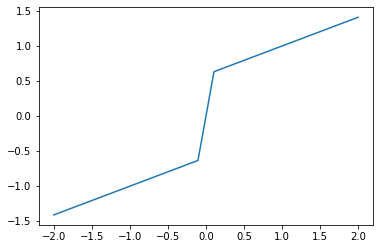

In [12]:
preds = MappingFunc.predict([[c] for c in np.linspace(2,2,20)])
plt.plot(np.linspace(-2,2,20),preds)

In [13]:
c_i = np.random.uniform(-1.5,1.5,m//10)
c_f = []


for j in range(m//10):
    preds = MappingFunc.predict([[c_i[j]]])
    c_f.append(preds[0,0])
    
        

Text(0, 0.5, 'final slope')

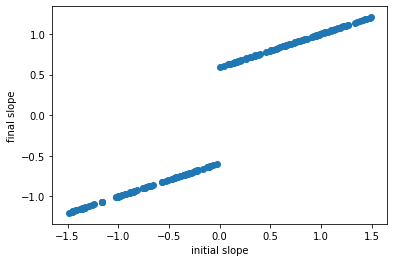

In [14]:
plt.scatter(c_i, c_f)
plt.xlabel("initial slope")
plt.ylabel("final slope")

In [15]:
x_real, y_real = generate_real_samples(10000)
x_fake, y_fake = generate_fake_samples(x_real, Generator, 10000)

(array([ 267.,  676., 1168., 1694., 1995., 1787., 1166.,  616.,  278.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

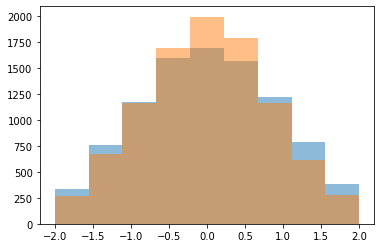

In [16]:
plt.hist(x_real[:,0],bins=np.linspace(-2,2,10),alpha=0.5)
plt.hist(x_fake[:,0],bins=np.linspace(-2,2,10),alpha=0.5)

In [36]:
np.mean(x_real[:,0])

-0.0012336223399872213

In [37]:
np.mean(x_fake[:,0])

0.0011748947770996892

In [2]:
plt.scatter(x_real[:,0],x_fake[:,0])

NameError: name 'x_real' is not defined

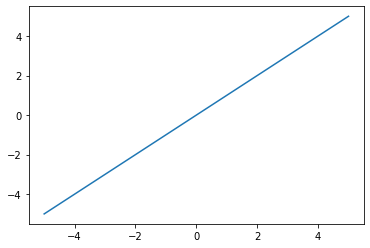

In [20]:
c = 1
X = np.linspace(-5, 5)
plt.plot(X, (1 - c) * tf.math.sign(X) + c * X)